# Taxi  Prediction Model

## Purpose

The purpose of this project is to create a model that predicts the amount of taxi orders for the next hour. The RMSE metric on the test set is required to be less than 48.

## Table of Contents
<a href='#Data Description'>Data Description</a>

<a href='#Data Resampling'>Data Resampling</a>

<a href='#Data Analysis'>Data Analysis</a>

<a href='#Model Development'>Model Development</a>

<a href='#Final Model Testing'>Final Model Testing</a>

<a href='#Overall Conclusion'>Overall Conclusion</a>

<a id='Data Description'></a>
## Data Description

Initially, a general look at the data is performed and the necessary libraries are imported. Since the target attribute is numerical, regression libraries are imported for the various machine learning models.

As the dataset of interest is a time series, the index of the dataframe will be set to the time, which will be sorted from past to present.

In [39]:
#Import necessary libraries
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import timeit
import warnings
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
#Import data and set the datetime column as the index
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

#Sort data by time
data.sort_index(inplace=True)

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [42]:
#prints the first and last time entries
print("The datetime span for the taxi orders is {} to {}.".format(data.index.min(),data.index.max()))

The datetime span for the taxi orders is 2018-03-01 00:00:00 to 2018-08-31 23:50:00.


The data has been sorted by chronological order. There are no missing values. The timeframe of the data is from March 1st, 2018 to August 31st, 2018.

<a id='Data Resampling'></a>
## Data Resampling

To prepare the data for further analysis and for model training, it is first resampled. An interval of an hour is selected since the model will be utilized to predict the number of rides for the upcoming hour. The total number of rides for each hour is determined.

In [43]:
#Resamples data by one hour and finds the sum
data = data.resample('1H').sum()

The rolling mean and standard deviation for a one-day period are then added to the existing dataframe. The rolling mean will better show how the number of orders changes on a daily basis. The expectation is that there will be a trend of an increase in the number of orders on certain days (Friday, Saturday, and Sunday), rather than a consistent number of orders for each day of the week.

Since data only exists for a six month timeframe, it is not possible to evaluate the seasonality.

In [44]:
#Adds a rolling mean and standard deviation of one day to the data frame
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()

<a id='Data Analysis'></a>
## Data Analysis

The resampled `num_orders` is plotted over the entire time frame along with the rolling 1-day mean and standard deviation to get a better understanding of how the data changes over time. 

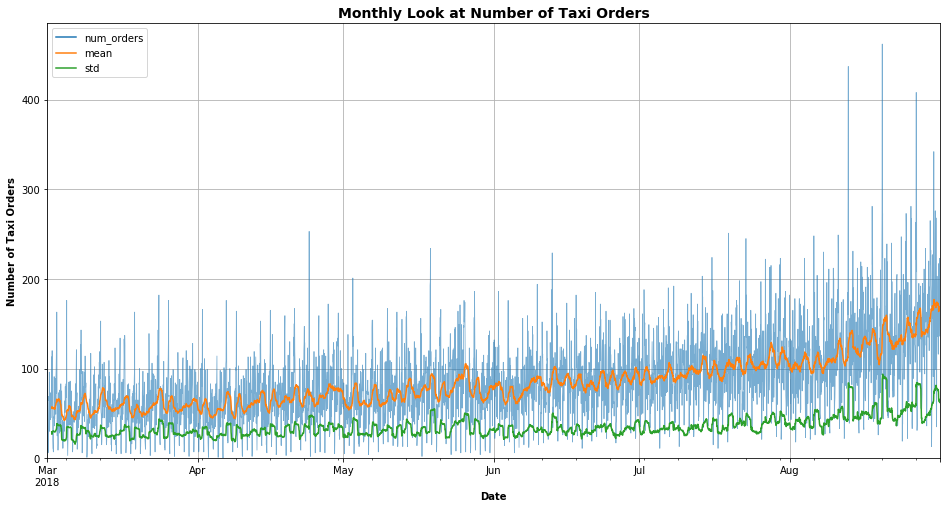

In [45]:
#Plots the resampled data including the rolling mean and standard deviation
ax = data.plot(grid = True, figsize = (16,8))
ax.lines[0].set_alpha(0.6)
ax.lines[0].set_linewidth(0.75)
plt.xlabel('Date', weight = 'bold')
plt.ylabel('Number of Taxi Orders', weight = 'bold')
plt.ylim(bottom = 0)
plt.title('Monthly Look at Number of Taxi Orders', weight = 'bold', size = 14)
plt.show()

Additionally, the trends and seasonality are plotted to understand the trends in the data and any patterns from the seasonality. Seasonality in it's true sense is not expected since data only exists for a single year; therefore, seasonality for a two week period is plotted instead to understand the daily seasonality.

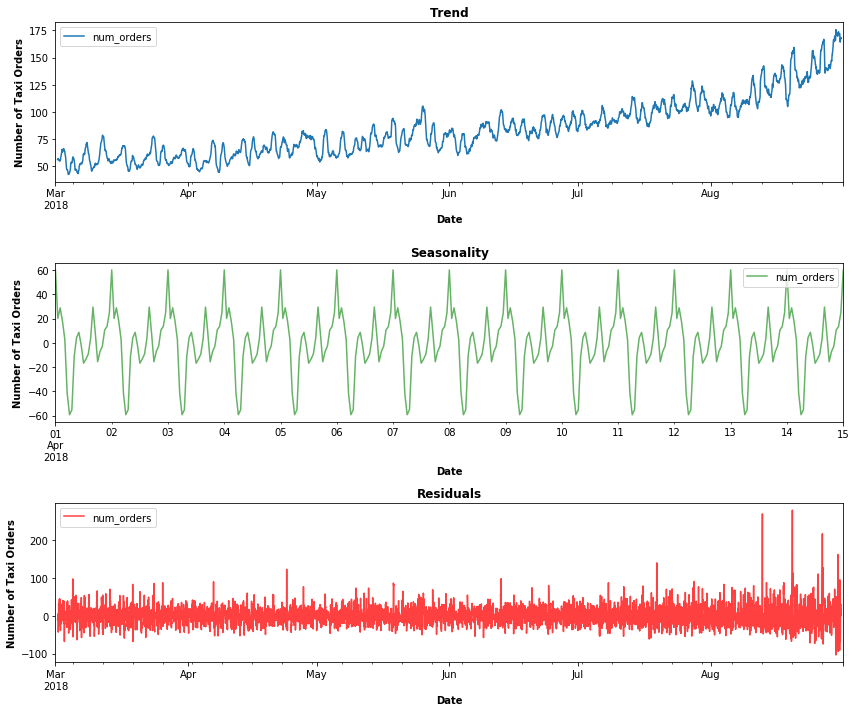

In [46]:
#Decomposes the number of orders data
decomposed = seasonal_decompose(data.drop(['mean', 'std'], axis=1).dropna())

#Plots three graphs, the trend, seasonality, and residuals
plt.figure(figsize=(12,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', weight = 'bold')
plt.xlabel('Date', weight = 'bold')
plt.ylabel('Number of Taxi Orders', weight = 'bold')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color = 'green', alpha = 0.6)
plt.title('Seasonality', weight = 'bold')
plt.xlabel('Date', weight = 'bold')
plt.ylabel('Number of Taxi Orders', weight = 'bold')
plt.xlim('2018-04-01', '2018-04-15')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color = 'red', alpha = 0.75)
plt.title('Residuals', weight = 'bold')
plt.xlabel('Date', weight = 'bold')
plt.ylabel('Number of Taxi Orders', weight = 'bold')

plt.tight_layout()

**Conclusion**

The number of taxi orders follows a fairly regular trend of the average number of orders increasing for a few days and then decreasing for a few days. This pattern repeats over the entire time series. From the months of March until the middle of May, the average number of orders remains roughly the same (a rolling 1-day mean of approximately 50 - 65 orders) for each month. However, once June hits, the average number of orders increases steadily, peaking at a rolling 1-day mean of approximately 175 at the end of August. Likewise, this time period witnesses the highest one-hour `num_orders` totals. This is likely attributed to the summer months where more people travel.

<a id='Model Development'></a>
## Model Development

For model development, the data must be separated into a training and testing dataset, as well as into features and targets. However, prior to doing this, features must be engineered for the dataset since the only existing feature is the index `datetime`. Since `num_orders` is expected to be dependent on the time of day and day of the week, these values will be extracted from the existing time series data and will be used for training. Additionally, the rolling mean and lag features for the past few days of `num_orders` will be used as features.

In [47]:
#This function performs three feature engineering techniques: (1) returns the respective month, day of the year, day of the week,
# and hour; (2) creates several lag features based on the desired input; and (3) creates a rolling mean feature based on the desired input
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

The `make_features` function is called using an arbitrary `max_lag` of 5, and a `rolling_mean_size` of 24 (one day). If necessary, these parameters could be tuned later on to get the best possible model.

In [48]:
#Rolling mean and std previous added are first removed from the dataframe
data.drop(['mean', 'std'], axis=1, inplace=True)

#Call make_features function
make_features(data, 5, 24)

With feature engineering complete, the data can be separated into a training and testing dataset, and the features and target can be selected. A ratio of 9:1 is selected for the size of the training dataset vs. the testing dataset. The training dataset is then separated into a validation dataset at a ratio of 8:2 for hyperparameter tuning.

In [49]:
#Splits dataset into training and testing, shuffles is set to false since it is a timeseries
train, test = train_test_split(data, shuffle=False, test_size = 0.1)

#Splits training dataset into training and validation
train, valid = train_test_split(train, shuffle=False, test_size = 0.2)

#Drop all missing values in the training dataset from the lag feature creation.
train = train.dropna()

#Selects targets and features for each dataset
train_features = train.drop(['num_orders'], axis = 1)
train_target = train['num_orders']
valid_features = valid.drop(['num_orders'], axis = 1)
valid_target = valid['num_orders']
test_features = test.drop(['num_orders'], axis = 1)
test_target = test['num_orders']

#Prints the first and last entries of each dataset to ensure order of the date was not compromised.
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-11 10:00:00
2018-07-11 11:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


### Sanity Check Model

A sanity check model will be created to verify the other models are working correctly, as well as to create a baseline root mean squared error (RMSE) value to compare the quality of the other model's against. The mean value for `num_orders` for the training dataset will be selected for the sanity check model.

In [50]:
#Creates a prediction matrix of the mean for every value
mean_prediction = np.ones(test['num_orders'].shape)*train['num_orders'].mean()

#Calculates the RMSE for the mean prediction matrix against the testing dataset
print('RMSE: {:.1f}'.format(mean_squared_error(test['num_orders'], mean_prediction)**0.5))

RMSE: 89.9


The RMSE of the mean value model does not meet the required value of 48, but it will be useful to sanity check the other models and as a baseline comparison.

In [51]:
baseline_RMSE = mean_squared_error(test['num_orders'], mean_prediction)**0.5

### Model Training

Three types of models will be trained and scored: a linear regression model, a random forest model, and a gradient boosting model (using LightGBM). For the random forest model and the gradient boosting model, various hyperparameters will be tuned against the validation dataset score, with the best model RMSE and the associated model hyperparameters being printed. The best model out of these iterations will be selected for evaluation against the testing dataset.

**Linear Regression**

In [52]:
#Creates a linear regression model and trains it against the training dataset. The RMSE is determined from the training dataset
lr_model = LinearRegression()

lr_model.fit(train_features, train_target)
lr_prediction = lr_model.predict(valid_features)

print('The RMSE for the linear regression model is {:.0f}.'.format(mean_squared_error(valid_target, lr_prediction)**0.5))

The RMSE for the linear regression model is 39.


**Random Forest**

The random forest model will tune the `n_estimators` and `max_depth` hyperparameters.

In [53]:
#Creates tuples of the various hyperparameter combinations
RF_params = [(n_estimators, max_depth) for n_estimators in range(50, 251, 50) for max_depth in range(2, 11, 2)]

#Sets initial values for the best score and parameters
best_RF_parameters = [0, 0]
best_RF_RMSE = baseline_RMSE

#Loops through each combination of hyperparameters. RMSE against the training set is determined for each iteration
for n_estimators, max_depth in reversed(RF_params):
    
    rf_model = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth, random_state=12345)
    rf_model.fit(train_features, train_target)
    rf_prediction = rf_model.predict(valid_features)
    
    #Ensures lowest RMSE out of each model iteration is stored
    if mean_squared_error(valid_target, rf_prediction)**0.5 < best_RF_RMSE:
        best_RF_RMSE = mean_squared_error(valid_target, rf_prediction)**0.5
        best_RF_parameters = [n_estimators, max_depth]
        
print('The best Random Forest RMSE is {:.0f}, which are from the following hyperparameters - n_estimators: {}, max tree depth: {}'.format(best_RF_RMSE, best_RF_parameters[0], best_RF_parameters[1]))

The best Random Forest RMSE is 32, which are from the following hyperparameters - n_estimators: 50, max tree depth: 10


# **LightGBM**

The LightGBM model will tune the `learning_rate`, `n_estimators`, and `max_depth` hyperparameters.

In [54]:
#Creates tuples of the various hyperparameter combinations
LGBM_params = [(learning_rate, iterations, depth) for learning_rate in [x/10 for x in range(1, 4)] for iterations in range(300, 601, 100) for depth in range(6, 11, 2)]

#Sets initial values for the best score and parameters
best_LGBM_parameters = [0, 0, 0]
best_LGBM_RMSE = baseline_RMSE

#Loops through each combination of hyperparameters. For each combination, the RMSE is determined from the training set
for learning_rate, iterations, depth in reversed(LGBM_params):
    
    LGBM_model = lgb.LGBMRegressor(learning_rate = learning_rate, n_estimators = iterations, max_depth = depth)
    LGBM_model.fit(train_features, train_target)
    LGBM_prediction = LGBM_model.predict(valid_features)

    #Ensures the lowest RMSE and associated hyperparameters are stored in the 'best' variables
    if mean_squared_error(valid_target, LGBM_prediction)**0.5 < best_LGBM_RMSE:
        best_LGBM_RMSE = mean_squared_error(valid_target, LGBM_prediction)**0.5
        best_LGBM_parameters = [learning_rate, iterations, depth]
        
print('The best RMSE is {:.0f}, which are from the following parameters - learning rate: {}, n-estimators: {}, max tree depth: {}'.format(best_LGBM_RMSE, best_LGBM_parameters[0], best_LGBM_parameters[1], best_LGBM_parameters[2]))

The best RMSE is 32, which are from the following parameters - learning rate: 0.1, n-estimators: 300, max tree depth: 6


**Conclusion**

The best RMSE for each type of model is as follows:

| Model Type        | RMSE |
|-------------------|------|
| Linear Regression | 39   |
| Random Forest     | 32   |
| Gradient Boosting | 32   |


The LightGBM model with the hyperparameters: `learning_rate` = 0.1, `n_estimators` = 300, and `max_depth` = 6, will be selected as the final model and will be tested against the testing dataset.

<a id='Final Model Testing'></a>
## Final Model Testing

The training and validation are combined into one dataset prior to training the final model.

In [55]:
#Concatenation of training and validation dataset
train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

#Creates a final LightGBM model using the ideal hyperparameters
final_model = lgb.LGBMRegressor(learning_rate = 0.1, n_estimators = 300, max_depth = 6)
final_model.fit(train_valid_features, train_valid_target)
test_prediction = final_model.predict(test_features)

print('The RMSE for the LightGBM model when evaluated against the testing dataset is {:.0f}.'.format(mean_squared_error(test_target, test_prediction)**0.5))

The RMSE for the LightGBM model when evaluated against the testing dataset is 46.


The RMSE for the selected LightGBM model is 46 when evaluated against the testing dataset. This RMSE meets the required value of 48. The RMSE increased significantly compared to the value of 1 against the training dataset. However, this is expected since that was the data the model was trained against.

<a id='Overall Conclusion'></a>
## Overall Conclusion

The purpose of this project was to develop a model to predict the number of taxis orders in the upcoming hour at the airport. The model was required to have an RMSE less than 48 on the testing dataset.

The data was downloaded and processed as a timeseries. The data was resampled by one hour and a rolling 1-day mean and standard deviation were determined which aided in observing trends in the data where the data increased and decreased repeatedly for a few days at a time. The mean number of taxi orders was consistent throughout the months of March through May, but once the summer months arrived that average steadily increased.

Several features were engineered to improve model training and quality. Three different types of models were trained tuned: linear regression model, random forest model, and LightGBM model. The LightGBM model was selected for the final model with it's exceptionally low RMSE on the training dataset; however, as expected, the RMSE did increase when tested against the testing dataset. The optimal LightGBM model resulted in a RMSE of 47 when testing against the testing dataset.